<a href="https://colab.research.google.com/github/AbrahamMulat/TensorFlow-deep-learning-Exercise-and-Project/blob/main/04_Transfer_learning_in_TensorFlow_part_1_feature_extraction_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🛠 04. Transfer Learning in TensorFlow Part 1: Feature Extraction Exercises

1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction ([mobilenet_v2_100_224/feature_vector](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4)) from TensorFlow Hub, how does it perform compared to our other models?
2. Name 3 different image classification models on TensorFlow Hub that we haven't used.
3. Build a model to classify images of two different things you've taken photos of.
* You can use any feature extraction layer from TensorFlow Hub you like for this.
* You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.
4. What is the current best performing model on ImageNet?
Hint: you might want to check sotabench.com for this.

### 1. Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [1]:
# Download the data (10% of labels)

import zipfile
# download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2022-10-18 07:25:40--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   276MB/s    in 0.6s    

2022-10-18 07:25:41 (276 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [2]:
# Unzip the downloaded data
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
import os

# Walk through 10 percent data directly and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [4]:
# check gpu availability
!nvidia-smi

Tue Oct 18 07:25:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Creating data loader (preparing the data)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images: ")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical")
print("Testing images: ")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")


In [9]:
# Create tensorboard callback
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name +"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [26]:
# Creating model using TensorFlow Hub

# Mobilenet v2 feature extractor
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5"


def create_model(model_url, num_classes=2):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.
  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, 
                                              name="feature_extractor_layer", 
                                              input_shape=(224,224,3))

  model = tf.keras.Sequential([
      feature_extractor_layer, 
      tf.keras.layers.Dense(num_classes, 
                            activation="softmax", 
                            name="output_layer")
                                  ])
  return model

In [9]:
# Create a model
mobilenet_model = create_model(mobilenet_url, num_classes=train_data_10_percent.num_classes)

# compile the model
mobilenet_model.compile(loss="categorical_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [10]:
# Fit the model
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=5,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        #Add TensorBoard callback to model (callbacks parameter takes a list)
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="mobilenet_V2_100_224")])

Saving TensorBoard log files to: tensorflow_hub/mobilenet_V2_100_224/20221018-072549
Epoch 1/5
24/24 [==============================] - 27s 918ms/step - loss: 2.0101 - accuracy: 0.3587 - val_loss: 1.1182 - val_accuracy: 0.6276
Epoch 2/5
24/24 [==============================] - 15s 637ms/step - loss: 0.8197 - accuracy: 0.7667 - val_loss: 0.7661 - val_accuracy: 0.7440
Epoch 3/5
24/24 [==============================] - 15s 649ms/step - loss: 0.5558 - accuracy: 0.8347 - val_loss: 0.6816 - val_accuracy: 0.7796
Epoch 4/5
24/24 [==============================] - 15s 638ms/step - loss: 0.4243 - accuracy: 0.8827 - val_loss: 0.6535 - val_accuracy: 0.7824
Epoch 5/5
24/24 [==============================] - 16s 666ms/step - loss: 0.3433 - accuracy: 0.9107 - val_loss: 0.6489 - val_accuracy: 0.7848


In [12]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

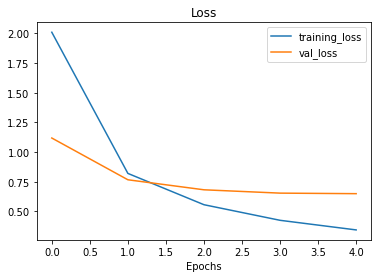

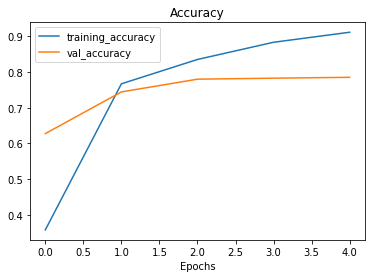

In [12]:
plot_loss_curves(mobilenet_history)

### 2. Name 3 different image classification models on TensorFlow Hub that you haven't used?

* Inception model
* NaSNet
* Vision Transformer, etc.

### 3. Build a model to classifiy images of two different things you have taken photos of.
* You can use any feature extraction layer from TensorFlow Hub you like for this.
* You should aim to have at least 10 images of each class, for example to build a fridge versus oven classifier, you'll want 10 images of fridges and 10 images of ovens.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
### Get data and unzip data

import zipfile

# unzip data
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/cats_and_dogs_10.zip")
zip_ref.extractall()
zip_ref.close()

In [3]:
import os

# walk through cats_and_dogs_10 directory and list numbers of files.
for dirpath, dirnames, filenames in os.walk("/content/cats_and_dogs_10"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are 3 directories and 0 images in '/content/cats_and_dogs_10'
There are 0 directories and 10 images in '/content/cats_and_dogs_10/test'
There are 2 directories and 0 images in '/content/cats_and_dogs_10/train'
There are 0 directories and 10 images in '/content/cats_and_dogs_10/train/dog'
There are 0 directories and 10 images in '/content/cats_and_dogs_10/train/cat'
There are 2 directories and 0 images in '/content/cats_and_dogs_10/validation'
There are 0 directories and 4 images in '/content/cats_and_dogs_10/validation/dog'
There are 0 directories and 4 images in '/content/cats_and_dogs_10/validation/cat'


In [4]:
# Visualize random images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class
  random_image = random.sample(os.listdir(target_folder), 1)
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  print(f"Image shape: {img.shape}")
  plt.title(target_class)
  plt.axis("off")

Image shape: (375, 499, 3)


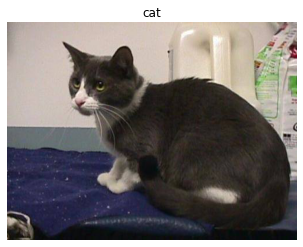

In [5]:
# Visualize a random images of cat from the training dataset
cat_img = view_random_image(target_dir="cats_and_dogs_10/train/", target_class="cat")

Image shape: (500, 368, 3)


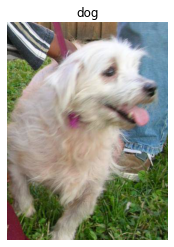

In [6]:
# Visualize a random images of dogs from the training dataset
dog_img = view_random_image(target_dir="cats_and_dogs_10/train/", target_class="dog")

In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set seed
tf.random.set_seed(42)

# Preprocess the data (normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "cats_and_dogs_10/train/"
test_dir = "cats_and_dogs_10/validation/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)
valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

Found 20 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


In [36]:
def create_model(model_url, num_classes=2):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.
  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # download the pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url, trainable=False, 
                                              name="feature_extractor_layer", 
                                              input_shape=(224,224,3))

  model = tf.keras.Sequential([
      feature_extractor_layer, 
      tf.keras.layers.Dense(1, 
                            activation="sigmoid", 
                            name="output_layer")
                                  ])
  return model

In [34]:
train_data.num_classes

2

In [37]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"
# Create a model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data.num_classes)

# compile the model
efficientnet_model.compile(loss="binary_crossentropy",
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [38]:
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=20,
                                              steps_per_epoch=len(train_data),
                                              validation_data=valid_data,
                                              validation_steps=len(valid_data))

Epoch 1/20
1/1 [==============================] - 19s 19s/step - loss: 0.7087 - accuracy: 0.5500 - val_loss: 0.6043 - val_accuracy: 0.8750
Epoch 2/20
1/1 [==============================] - 0s 183ms/step - loss: 0.6609 - accuracy: 0.6000 - val_loss: 0.5745 - val_accuracy: 0.8750
Epoch 3/20
1/1 [==============================] - 0s 171ms/step - loss: 0.6158 - accuracy: 0.7000 - val_loss: 0.5462 - val_accuracy: 0.8750
Epoch 4/20
1/1 [==============================] - 0s 179ms/step - loss: 0.5733 - accuracy: 0.7500 - val_loss: 0.5195 - val_accuracy: 0.8750
Epoch 5/20
1/1 [==============================] - 0s 180ms/step - loss: 0.5334 - accuracy: 0.8500 - val_loss: 0.4942 - val_accuracy: 0.8750
Epoch 6/20
1/1 [==============================] - 0s 178ms/step - loss: 0.4959 - accuracy: 0.9000 - val_loss: 0.4704 - val_accuracy: 0.8750
Epoch 7/20
1/1 [==============================] - 0s 182ms/step - loss: 0.4610 - accuracy: 0.9000 - val_loss: 0.4478 - val_accuracy: 0.8750
Epoch 8/20
1/1 [=====

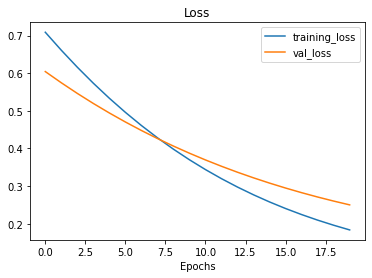

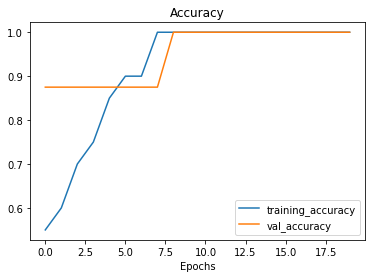

In [39]:
plot_loss_curves(efficientnet_history)

In [41]:
images, labels = train_data.next()
len(images), len(labels)

(20, 20)

In [42]:
images[0].shape

(224, 224, 3)

In [ ]:
images[0]

In [44]:
labels[0]

1.0

## Make a prediction with our trained model (efficientnet)

In [50]:
# check number of class
print(train_data.num_classes)

2


In [53]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/cats_and_dogs_10/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['cat' 'dog']


In [51]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [52]:
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 1s 1s/step


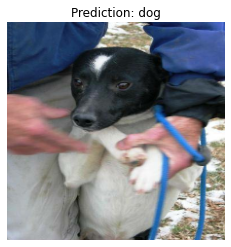

In [54]:
# Test our model on a custom image
pred_and_plot(efficientnet_model, "/content/cats_and_dogs_10/test/1.jpg", class_names)

1/1 [==============================] - 0s 68ms/step


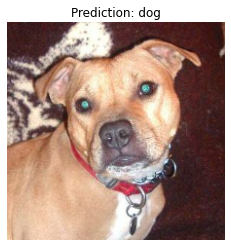

In [55]:
pred_and_plot(efficientnet_model, "/content/cats_and_dogs_10/test/2.jpg", class_names)

1/1 [==============================] - 0s 26ms/step


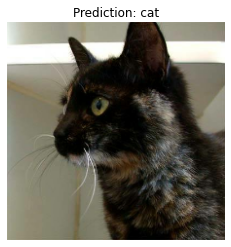

In [56]:
pred_and_plot(efficientnet_model, "/content/cats_and_dogs_10/test/5.jpg", class_names)

1/1 [==============================] - 0s 64ms/step


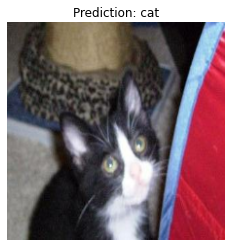

In [57]:
pred_and_plot(efficientnet_model, "/content/cats_and_dogs_10/test/8.jpg", class_names)

1/1 [==============================] - 0s 66ms/step


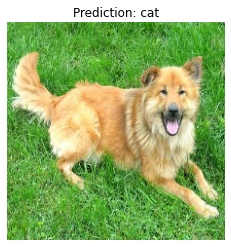

In [58]:
pred_and_plot(efficientnet_model, "/content/cats_and_dogs_10/test/4.jpg", class_names)

### 4. What is the current best performing model on ImageNet?

The best performing model for image classification on ImageNet at the moment is **CoCa(finetuned)** - Top 1 accuracy **91%**

src = https://paperswithcode.com/sota/image-classification-on-imagenet
